# Exploratory Data Analysis
### Kwame V. Taylor

## Set up Environment

In [1]:
import pandas as pd
import numpy as np

from math import sqrt
from scipy import stats

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib as mpl
import seaborn as sns
from cycler import cycler

# default viz size settings
sns.set(rc={'figure.figsize':(11, 8)})
plt.rc('figure', figsize=(11, 8))
plt.rc('font', size=16)
mpl.rcParams['figure.figsize'] = 11, 8
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '--'
mpl.rcParams['axes.prop_cycle'] = cycler(color=['deepskyblue', 'firebrick', 'darkseagreen', 'violet'])

In [2]:
from prepare import handle_nulls
from preprocessing import spotify_split, scale_data

## Acquire data

In [3]:
df = pd.read_csv('full-playlist.csv', index_col=0)

In [4]:
df.head()

,artist,album,release_date,track_name,album_popularity,label,danceability,energy,key,loudness,...,disc_number,track_number,album_id,album_type,duration_seconds,duration_minutes,is_featured_artist,release_year,release_month,release_day
track_id,,,,,,,,,,,,,,,,,,,,,
6mecZbKK3JDeMdFRNxsCV5,tay-k,trapman,2020-07-12,trapman,36,Tay-K,0.792,0.594,2,-8.544,...,1,1,2J1hMj78HfdcMrmL2Sk6eR,single,232,3,0,2020,7,12
5PtMwNq8Dp31uYdGGacVJE,lil wyte,doubt me now,2003-03-04,oxy cotton,55,Hypnotize Minds Productions,0.816,0.578,9,-6.912,...,1,11,2lwxcemR1muymEHNMblCpm,album,193,3,0,2003,3,4
6s8EhlBn2PIoESylkXnwYc,kamelen,kingpin slim,2019-11-29,kingpin o.g - remix,46,NMG/G-HUSET,0.649,0.798,0,-6.450,...,1,11,6va2RTYO2ois7t88RN0LhJ,album,254,4,0,2019,11,29
2e9EZ2V5QGGZPMJacO3y0Y,waka flocka flame,flockaveli,2010-10-01,grove st. party (feat. kebo gotti),71,Asylum/Warner Records,0.705,0.702,0,-4.783,...,1,9,6MQtWELG7aRX7CkAzQ6nLM,album,250,4,1,2010,10,1
3ZRd5Z0fiYtASLdEPPb16m,project pat,mista don't play: everythangs workin',2001-02-13,don't save her (feat. crunchy black),55,Hypnotize Minds Productions,0.838,0.793,11,-5.470,...,1,5,4QzaueQPQa0lqrMmQoh4v0,album,261,4,1,2001,2,13


In [5]:
df.shape

(5733, 30)

## Prepare data

In [6]:
# handle null values
df = handle_nulls(df)

# split the data
X_train, y_train, X_validate, y_validate, X_test, y_test, train, validate, test = spotify_split(df, 'popularity')
train.head()

Shape of train: (4012, 29) | Shape of validate: (861, 29) | Shape of test: (860, 29)
Percent train: 70.0        | Percent validate: 15.0       | Percent test: 15.0


,artist,album,release_date,track_name,album_popularity,label,danceability,energy,key,loudness,...,disc_number,track_number,album_id,album_type,duration_seconds,duration_minutes,is_featured_artist,release_year,release_month,release_day
track_id,,,,,,,,,,,,,,,,,,,,,
30bqVoKjX479ab90a8Pafp,lil peep,star shopping,2019-04-19,star shopping,80,Lil Peep,0.585,0.471,4,-9.934,...,1,1,1dEpGPZONvmwYlE2jDOWOM,single,142,2,0,2019,4,19
0HO8pCseEpgozNi3z0R4bc,father,who's gonna get fucked first?,2015-03-17,everybody in the club gettin shot,26,Awful Records,0.833,0.518,10,-10.126,...,1,11,1ecx4skUBpk31GDJlMXi3X,album,120,2,0,2015,3,17
643K3eEgRvdJiXjSzlz7dg,m.o.p.,first family 4 life,1998-08-11,breakin' the rules,36,Relativity Records,0.471,0.671,1,-6.050,...,1,2,3kaX938EVrZuYE1JpNhZIW,album,252,4,0,1998,8,11
08EabdvPIHC4KBW7LfynPP,salt-n-pepa,very necessary,1993-10-12,no one does it better,64,Mercury Records,0.874,0.507,6,-10.076,...,1,2,2W2EmEpud13QHlhCFS9P8g,album,234,3,0,1993,10,12
6B2ZDVgJ0lHLgV9xC2PAJh,dungeon family,even in darkness,2001-10-22,white gutz (feat. bubba sparxxx),42,Arista,0.857,0.808,6,-5.468,...,1,9,2n4GKr0nKfFWoSTWZuNB9Z,album,266,4,1,2001,10,22


In [7]:
train.columns

Index(['artist', 'album', 'release_date', 'track_name', 'album_popularity',
       'label', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'explicit', 'popularity',
       'disc_number', 'track_number', 'album_id', 'album_type',
       'duration_seconds', 'duration_minutes', 'is_featured_artist',
       'release_year', 'release_month', 'release_day'],
      dtype='object')

# Does a track being explicit or not correlate with its popularity?

### Swarm plot

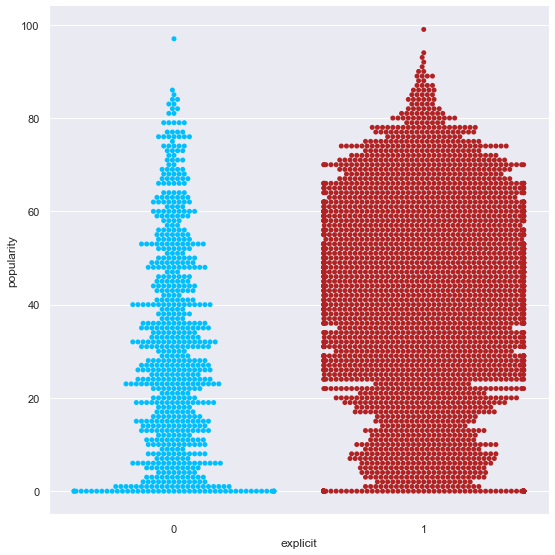

In [8]:
sns.catplot(x="explicit", y="popularity", kind="swarm", data=train, height=8, aspect=1)

### Independent T-Test

The features are independent because there is no overlap between observations in explicit and observations in not explicit.

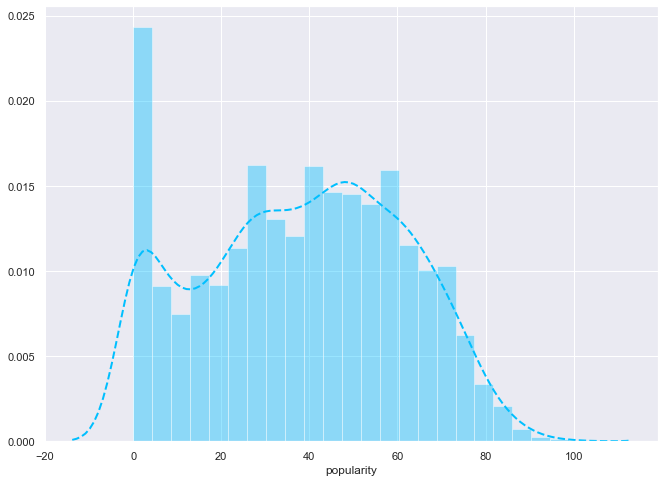

In [9]:
# check for normal distribution
sns.distplot(train.popularity)

In [10]:
train.explicit.value_counts()

1    3278
0     734
Name: explicit, dtype: int64

In [11]:
# compare variances
explicit_sample = train[train.explicit==True].popularity
not_explicit_sample = train[train.explicit==False].popularity

print(explicit_sample.var())
print(not_explicit_sample.var())

513.3408193032112
505.0351342510156


No, so we will set the argument of equal_var to False.

**Set hypothesis and alpha:**

$H_{0}$: Mean of song popularity of explicit tracks = Mean of song popularity of non-explicit tracks

$H_{a}$: Mean of song popularity of explicit tracks > Mean of song popularity of non-explicit tracks

$\alpha$: .05

In [12]:
alpha = .05

**Compute test statistic and probability (t-statistic & p-value)**

In [13]:
t, p = stats.ttest_ind(explicit_sample, not_explicit_sample, equal_var = False)

print('Test statistic:', t, '\n', p/2, '\n', alpha)

Test statistic: 10.033800284729889 
 5.039263790755597e-23 
 0.05


**Decide**

In [14]:
null_hypothesis = "there is no significant difference between the mean popularity of explicit tracks and non-explicit tracks."

if p/2 < alpha:
    print("We reject the hypothesis that", null_hypothesis)
else:
    print("We fail to reject the null hypothesis.")

We reject the hypothesis that there is no significant difference between the mean popularity of explicit tracks and non-explicit tracks.


In [15]:
not_explicit_sample.mean(), explicit_sample.mean()

(30.79700272479564, 40.01860890787065)

Now put it in a function:

In [16]:
def explicit_viz(df):
    '''
    This function produces a swarm plot on explicit tracks' and non-explicit tracks' popularity.
    '''
    print('Does a track being explicit or not correlate with its popularity?')
    sns.catplot(x="explicit", y="popularity", kind="swarm", data=df)

In [34]:
def explicit_ttest(df, alpha):
    print('Set the alpha/significance level:')
    print('  alpha =', alpha)
    
    print('\n---\n')
    
    print('Check for normal distribution:')
    sns.distplot(df.popularity)
    plt.show()
    
    print('---\n')
    
    print('Check values counts:')
    print(df.explicit.value_counts())
    
    print('\n---\n')
    
    print('Compare variances:')
    explicit_sample = df[df.explicit==True].popularity
    not_explicit_sample = df[df.explicit==False].popularity
    
    # if [results of lavenes variance test], then equal_var = __ (automate checking similar variance)
    print(explicit_sample.var())//
    print(not_explicit_sample.var())
          
    print("They are of similar variance, so we will set the argument of equal_var to True.")
    
    print('\n---\n')
          
    print("Compute test statistic and probability (t-statistic & p-value)")
    t, p = stats.ttest_ind(explicit_sample, not_explicit_sample, equal_var = True)
    print('Test statistic:', t, '\np-value:', p/2, '\nalpha:', alpha)
    
    print('\n---\n')
    
    null_hypothesis = "there is no significant difference between the mean popularity of explicit tracks and non-explicit tracks."
    if p/2 < alpha:
        print("We reject the hypothesis that", null_hypothesis)
    else:
        print("We fail to reject the null hypothesis.")
        
    print('\n---\n')
          
    print('mean of non-explicit songs:', not_explicit_sample.mean(), '\nmean of explicit songs:', explicit_sample.mean())

SyntaxError: invalid syntax (<ipython-input-34-909d2d3e2500>, line 23)

Set the alpha/significance level:
  alpha = 0.05

---

Check for normal distribution:


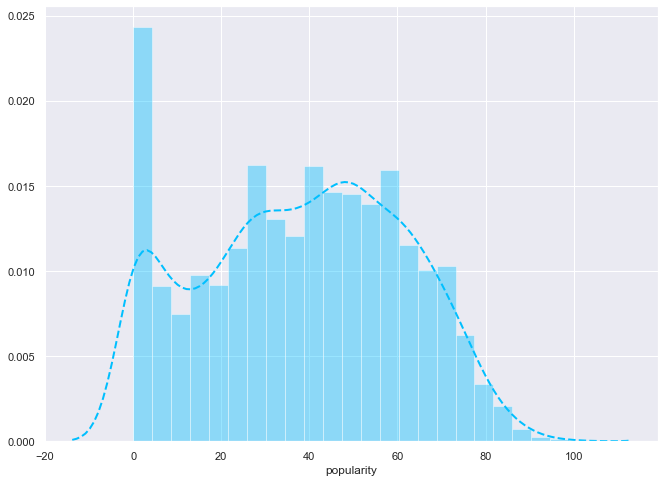

---

Check values counts:
1    3278
0     734
Name: explicit, dtype: int64

---

Compare variances:
513.3408193032112
505.0351342510156
They are not equal, so we will set the argument of equal_var to False.

---

Compute test statistic and probability (t-statistic & p-value)
Test statistic: 9.98203033281764 
p-value: 1.699938409787861e-23 
alpha: 0.05

---

We reject the hypothesis that there is no significant difference between the mean popularity of explicit tracks and non-explicit tracks.

---

mean of non-explicit songs: 30.79700272479564 
mean of explicit songs: 40.01860890787065


In [35]:
explicit_ttest(train, alpha)

# Does loudness have a relationship with popularity?

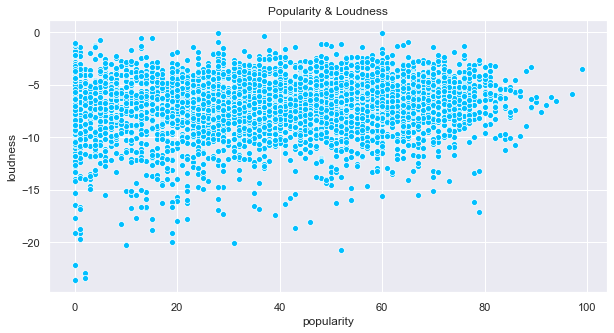

In [19]:
plt.figure(figsize=(10,5))
plt.title('Popularity & Loudness')
plt.ylabel('Loudness')
plt.xlabel('Popularity')
sns.scatterplot(train['popularity'], train['loudness'])
plt.show()

Doesn't appear to be any valuable insights here.

# Are originals or remixes more popular?

In [36]:
train[train.track_name.str.contains('remix', case=True, flags=0, regex=False)]

,artist,album,release_date,track_name,album_popularity,label,danceability,energy,key,loudness,...,track_number,album_id,album_type,duration_seconds,duration_minutes,is_featured_artist,release_year,release_month,release_day,instrumentalness_boolean
track_id,,,,,,,,,,,,,,,,,,,,,
1IlJZCRthVEPlksVzj3JWY,sada baby,whole lotta choppas (remix) [feat. nicki minaj],2020-10-16,whole lotta choppas (remix) [feat. nicki minaj],65,Asylum Worldwide LLC,0.956,0.720,10,-2.730,...,1,6xVP3wpk1yUu8X7zN9gzDW,single,173,2,1,2020,10,16,False
6s8EhlBn2PIoESylkXnwYc,kamelen,kingpin slim,2019-11-29,kingpin o.g - remix,46,NMG/G-HUSET,0.649,0.798,0,-6.450,...,11,6va2RTYO2ois7t88RN0LhJ,album,254,4,0,2019,11,29,False
11YP90W36r34d2qrjAcPq4,queen key,my way (remix),2018-10-19,my way (remix),29,Machine Entertainment Group,0.849,0.843,2,-3.246,...,1,1tA4lVAHNN3vzi1wkib765,single,207,3,0,2018,10,19,False
3gTpy8lhCIyNWSVQxEpdBi,"juvenile, skip, wacko",the beginning of the end...,2004-05-14,nolia clap - remix,0,Rap-A-Lot Fontana,0.789,0.942,1,-2.061,...,12,2kQdSqJ8IHvfCn12dJnGdf,album,270,4,0,2004,5,14,False
60eZwR3BMCP2yVkUBsD69O,lil loaded,6locc 6a6y (feat. nle choppa) [remix],2020-06-19,6locc 6a6y (feat. nle choppa) - remix,58,Lil Loaded Music,0.862,0.673,5,-9.111,...,1,1Ow2q6JhpvzltkIEqar3Ib,single,176,2,1,2020,6,19,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6MO2bfLHKykUgCChFdw91H,h.e.r.,"slide (remix) (feat. pop smoke, a boogie wit d...",2020-01-17,"slide (remix) (feat. pop smoke, a boogie wit d...",70,MBK Entertainment/RCA Records,0.815,0.513,1,-8.363,...,1,7LMJKPGcBZjZf6AEnTBS2t,single,296,4,1,2020,1,17,True
0XkmeG97T4mtYlWRJcrxec,staysolidrocky,party girl (remix),2020-07-10,party girl (remix),63,Columbia,0.752,0.375,6,-10.157,...,1,0K3zXpDvZE6iKNMwxoj7rY,single,147,2,0,2020,7,10,False
35KcXRWo7BTYdJiyMOy2Zu,various artists,can't hardly wait,1998-05-26,swing my way - remix,50,Elektra Records,0.769,0.636,5,-7.168,...,7,5Rb6Q94DDEPWakydob5bPp,compilation,248,4,0,1998,5,26,True


In [37]:
train[train.track_name.str.contains('pop, lock', case=True, flags=0, regex=False)]

,artist,album,release_date,track_name,album_popularity,label,danceability,energy,key,loudness,...,track_number,album_id,album_type,duration_seconds,duration_minutes,is_featured_artist,release_year,release_month,release_day,instrumentalness_boolean
track_id,,,,,,,,,,,,,,,,,,,,,
5N6USyYyAuSyysUQ1xncYc,itsoktocry,pastelgore,2018-03-18,"pop, lock & dropdead",53,27club,0.985,0.438,1,-11.004,...,3,1CfdFbMoLHW9nOpcaxXRoz,single,138,2,0,2018,3,18,True
2smQB1lhS08j7Rkt16rXBb,huey,notebook paper,2007-06-19,"pop, lock & drop it (feat. bow wow & t-pain) -...",28,Jive,0.802,0.689,0,-6.264,...,14,5OiONKaFzoZiFTxs5cZNTw,album,269,4,1,2007,6,19,False
19UUPNx5jccGgQ2GCIZkww,huey,"pop, lock & drop it",2006-09-19,"pop, lock & drop it",44,Jive/Legacy,0.745,0.568,0,-8.332,...,1,5gfpFBNS5wHsVd9NRlxosi,album,263,4,0,2006,9,19,False
4Vs8nLCu2AK9ec9QiCd4hJ,various artists,highlights from stomp the yard,2011-08-16,"pop, lock & drop it",23,Platinum Collection,0.805,0.809,9,-5.826,...,4,13vzURZ4ysMf7H4EyYd6vj,compilation,260,4,0,2011,8,16,False


In [38]:
train.columns

Index(['artist', 'album', 'release_date', 'track_name', 'album_popularity',
       'label', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'explicit', 'popularity',
       'disc_number', 'track_number', 'album_id', 'album_type',
       'duration_seconds', 'duration_minutes', 'is_featured_artist',
       'release_year', 'release_month', 'release_day',
       'instrumentalness_boolean'],
      dtype='object')

There are not enough remixes and originals to compare.

# What are the drivers of popularity?

In [22]:
def corr_heatmap(train):
    '''
    This function creates a heatmap of the correlation of all features scaled, minus longitude and latitude and redundant features.
    Takes a dataFrame as an argument
    '''
    # heatmap time!
    heatmap_data = train
    corr = heatmap_data.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    ax = sns.heatmap(corr, mask=mask, center=0, vmin=0, vmax=1, cmap=sns.diverging_palette(95, 220, n=250, s=93, l=35), square=True) 
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
    plt.title('Which features have significant correlation?')
    ax

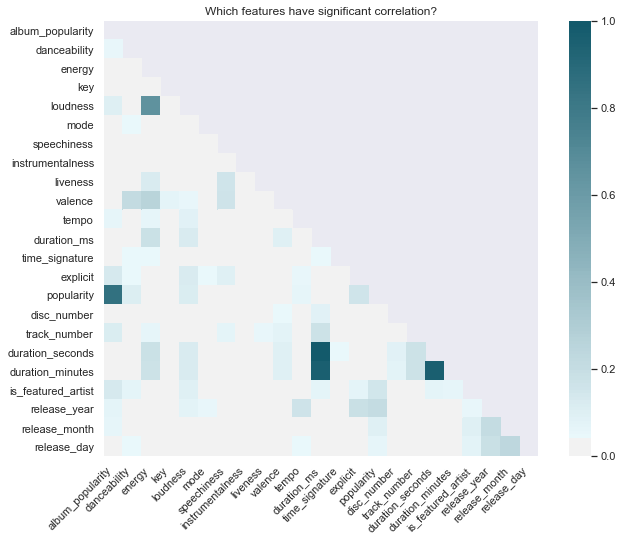

In [23]:
corr_heatmap(train.drop(columns=['artist', 'album', 'track_name', 'release_date']))

Looks like the top drivers of popularity across all of the tracks are danceability, instrumentalness, and explicit.

# Do instrumentals/lyrics have an effect on popularity?

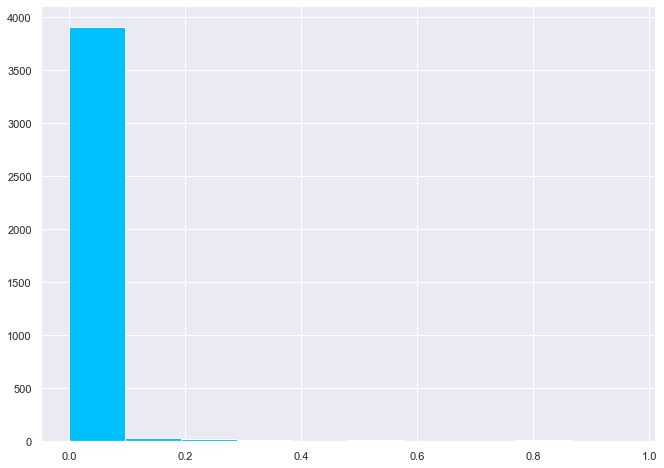

In [24]:
train.instrumentalness.hist()

In [25]:
train.instrumentalness.value_counts()

0.000000    2441
0.000001       6
0.000015       5
0.000029       5
0.000001       5
            ... 
0.000055       1
0.013800       1
0.011900       1
0.000009       1
0.003320       1
Name: instrumentalness, Length: 1246, dtype: int64

In [26]:
train.instrumentalness.max()

0.9620000000000001

In [27]:
train['instrumentalness_boolean'] = train["instrumentalness"] > 0.0
train.head()

,artist,album,release_date,track_name,album_popularity,label,danceability,energy,key,loudness,...,track_number,album_id,album_type,duration_seconds,duration_minutes,is_featured_artist,release_year,release_month,release_day,instrumentalness_boolean
track_id,,,,,,,,,,,,,,,,,,,,,
30bqVoKjX479ab90a8Pafp,lil peep,star shopping,2019-04-19,star shopping,80,Lil Peep,0.585,0.471,4,-9.934,...,1,1dEpGPZONvmwYlE2jDOWOM,single,142,2,0,2019,4,19,True
0HO8pCseEpgozNi3z0R4bc,father,who's gonna get fucked first?,2015-03-17,everybody in the club gettin shot,26,Awful Records,0.833,0.518,10,-10.126,...,11,1ecx4skUBpk31GDJlMXi3X,album,120,2,0,2015,3,17,False
643K3eEgRvdJiXjSzlz7dg,m.o.p.,first family 4 life,1998-08-11,breakin' the rules,36,Relativity Records,0.471,0.671,1,-6.050,...,2,3kaX938EVrZuYE1JpNhZIW,album,252,4,0,1998,8,11,False
08EabdvPIHC4KBW7LfynPP,salt-n-pepa,very necessary,1993-10-12,no one does it better,64,Mercury Records,0.874,0.507,6,-10.076,...,2,2W2EmEpud13QHlhCFS9P8g,album,234,3,0,1993,10,12,False
6B2ZDVgJ0lHLgV9xC2PAJh,dungeon family,even in darkness,2001-10-22,white gutz (feat. bubba sparxxx),42,Arista,0.857,0.808,6,-5.468,...,9,2n4GKr0nKfFWoSTWZuNB9Z,album,266,4,1,2001,10,22,True


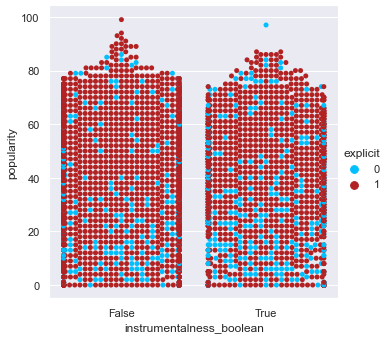

In [28]:
sns.catplot(x="instrumentalness_boolean", y="popularity", hue="explicit", kind="swarm", data=train)

There doesn't appear to be a significant difference in popularity between songs with a 0.0 amount of instrumentalness, and songs that have over 0.0 amount of instrumentalness.

## Further feature engineering

In [29]:
train.head()

,artist,album,release_date,track_name,album_popularity,label,danceability,energy,key,loudness,...,track_number,album_id,album_type,duration_seconds,duration_minutes,is_featured_artist,release_year,release_month,release_day,instrumentalness_boolean
track_id,,,,,,,,,,,,,,,,,,,,,
30bqVoKjX479ab90a8Pafp,lil peep,star shopping,2019-04-19,star shopping,80,Lil Peep,0.585,0.471,4,-9.934,...,1,1dEpGPZONvmwYlE2jDOWOM,single,142,2,0,2019,4,19,True
0HO8pCseEpgozNi3z0R4bc,father,who's gonna get fucked first?,2015-03-17,everybody in the club gettin shot,26,Awful Records,0.833,0.518,10,-10.126,...,11,1ecx4skUBpk31GDJlMXi3X,album,120,2,0,2015,3,17,False
643K3eEgRvdJiXjSzlz7dg,m.o.p.,first family 4 life,1998-08-11,breakin' the rules,36,Relativity Records,0.471,0.671,1,-6.050,...,2,3kaX938EVrZuYE1JpNhZIW,album,252,4,0,1998,8,11,False
08EabdvPIHC4KBW7LfynPP,salt-n-pepa,very necessary,1993-10-12,no one does it better,64,Mercury Records,0.874,0.507,6,-10.076,...,2,2W2EmEpud13QHlhCFS9P8g,album,234,3,0,1993,10,12,False
6B2ZDVgJ0lHLgV9xC2PAJh,dungeon family,even in darkness,2001-10-22,white gutz (feat. bubba sparxxx),42,Arista,0.857,0.808,6,-5.468,...,9,2n4GKr0nKfFWoSTWZuNB9Z,album,266,4,1,2001,10,22,True
